In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns
sns.set()
from matplotlib.backends.backend_pdf import PdfPages
#from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.colors as col
import matplotlib as mpl
import numpy as np #import for transposing
import math
import pylab as pl
import mpld3 as ml
import math
import import_ipynb
from sklearn.metrics import mean_squared_error,mean_absolute_error
from function_log import add_tdate,get_week,density_interp,extract_date,qtr_comp,IC_run_sim,new_compare,stoch_model,run_sim

import lhsmdu
import random

In [8]:
res = pd.read_csv('../ABC_estimation/final_run/param_est.csv')
res = res.drop(['Unnamed: 5','obs_troop.1','obs_tdint.1','age_class.1','iteration.1'],axis=1)
for col in ['obs_tdint', 'obs_quarter', 'iteration',
       'quarter', 'obs_min', 'obs_max', 'obs_mean', 'obs_var', 'sim_min',
       'sim_max', 'sim_mean', 'sim_var', 'abs_err', 'rel_err',
       'NRMSE', 'sMAPE', 'fus_fis','no_ev', 'rt_chg', 'b_j', 'd_j',
       'd_s', 'd_a', 'ae_j','ae_s','ae_a','t_p', 'por', 'fsr','thresh', 'fis_thresh','lit_size']:
    res.loc[:,col] = pd.to_numeric(res.loc[:,col])

In [9]:
res.columns

Index(['Unnamed: 0', 'obs_troop', 'obs_tdint', 'obs_quarter', 'age_class',
       'iteration', 'quarter', 'obs_min', 'obs_max', 'obs_mean', 'obs_var',
       'sim_min', 'sim_max', 'sim_mean', 'sim_var', 'abs_err', 'rel_err',
       'NRMSE', 'sMAPE', 'IC', 'fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j',
       'd_s', 'd_a', 'ae_j', 'ae_s', 'ae_a', 't_p', 'por', 'fsr', 'thresh',
       'fis_thresh', 'lit_size', 'dfe'],
      dtype='object')

In [10]:
res.shape

(1691392, 37)

# Results

## By NRMSE

In [16]:
nrmse = res.sort_values(by = ['NRMSE'])
nrmse = nrmse[np.isnan(nrmse.NRMSE)==False]
nrmse = nrmse[nrmse.NRMSE <= .05]
len(nrmse)

11077

In [17]:
len(nrmse[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size']].drop_duplicates())

95

This indicates that 95 parameter sets produces a less than 5% at least once for a given initial condition

In [22]:
nrmse = res[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','NRMSE','rel_err','sMAPE']]
nrmse = nrmse[nrmse.NRMSE==0]
nrmse.sort_values(by=['rel_err','NRMSE'])
test = nrmse[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size']].drop_duplicates()
test.shape

(95, 16)

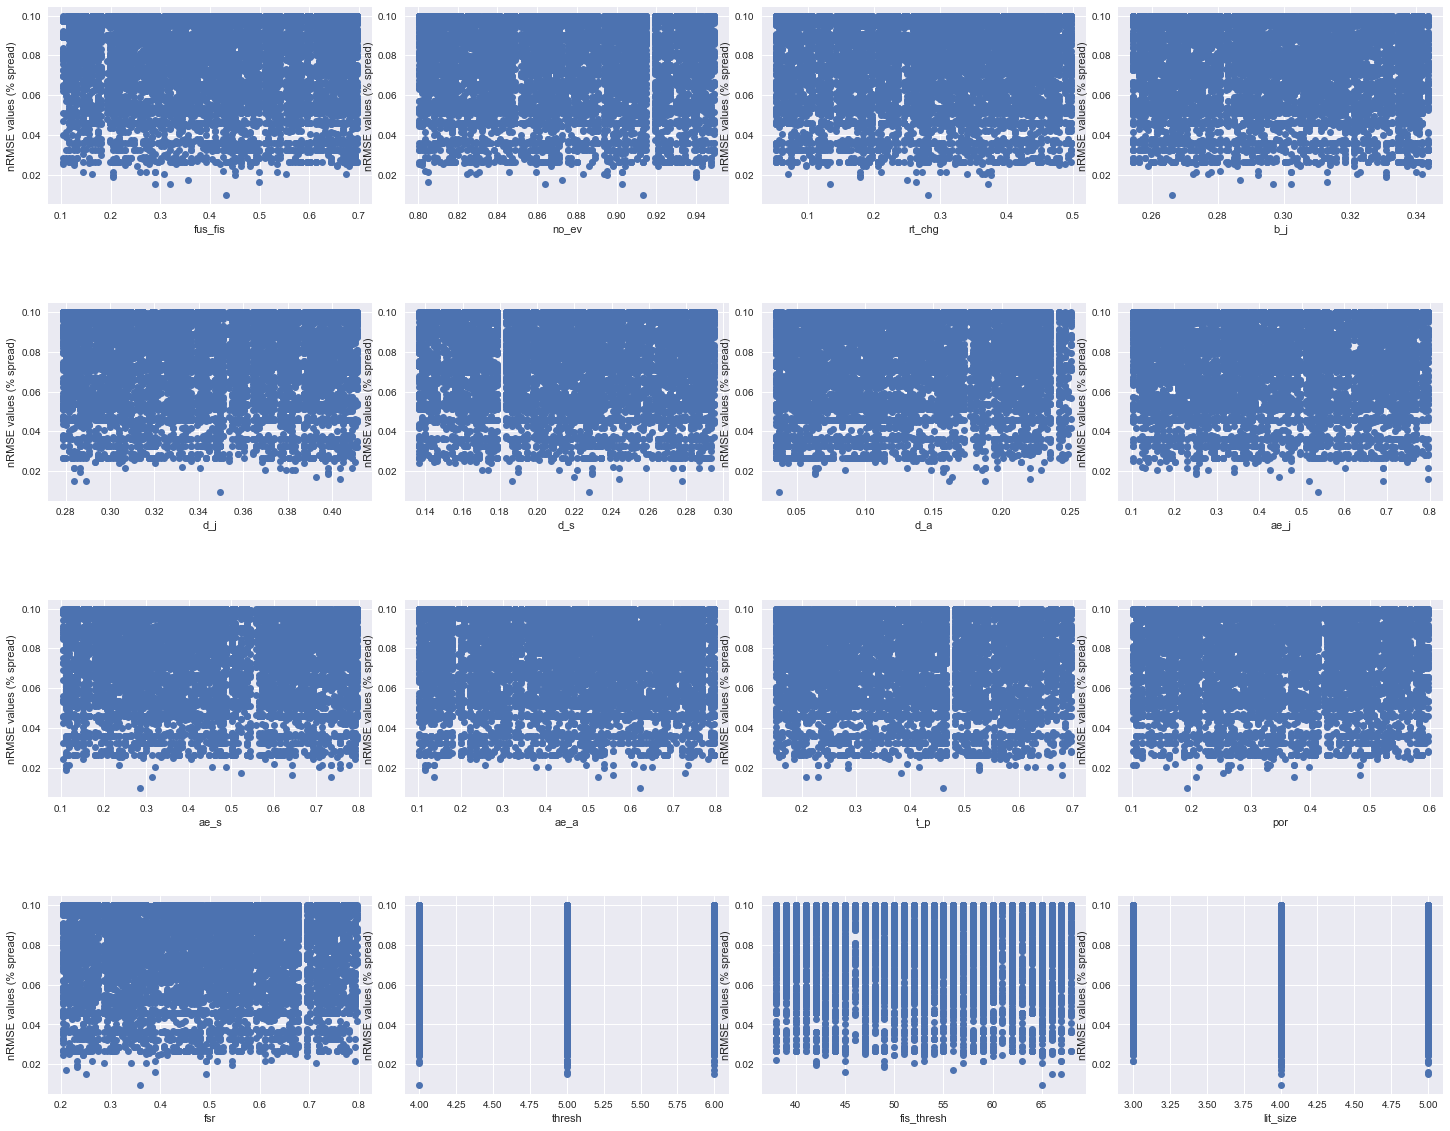

In [29]:
##Important parameters selected through RFE below

param_names = ['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size']

temp = res.loc[(res.NRMSE !=0)&(res.NRMSE <= 0.1)]

fig, axs = plt.subplots(4,4, figsize=(25, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

axs = axs.ravel()

for i in range(len(param_names)):
    axs[i].plot(temp[param_names[i]],temp.NRMSE,inp)
    axs[i].set_xlabel(param_names[i])
    axs[i].set_ylabel('nRMSE values (% spread)')
    

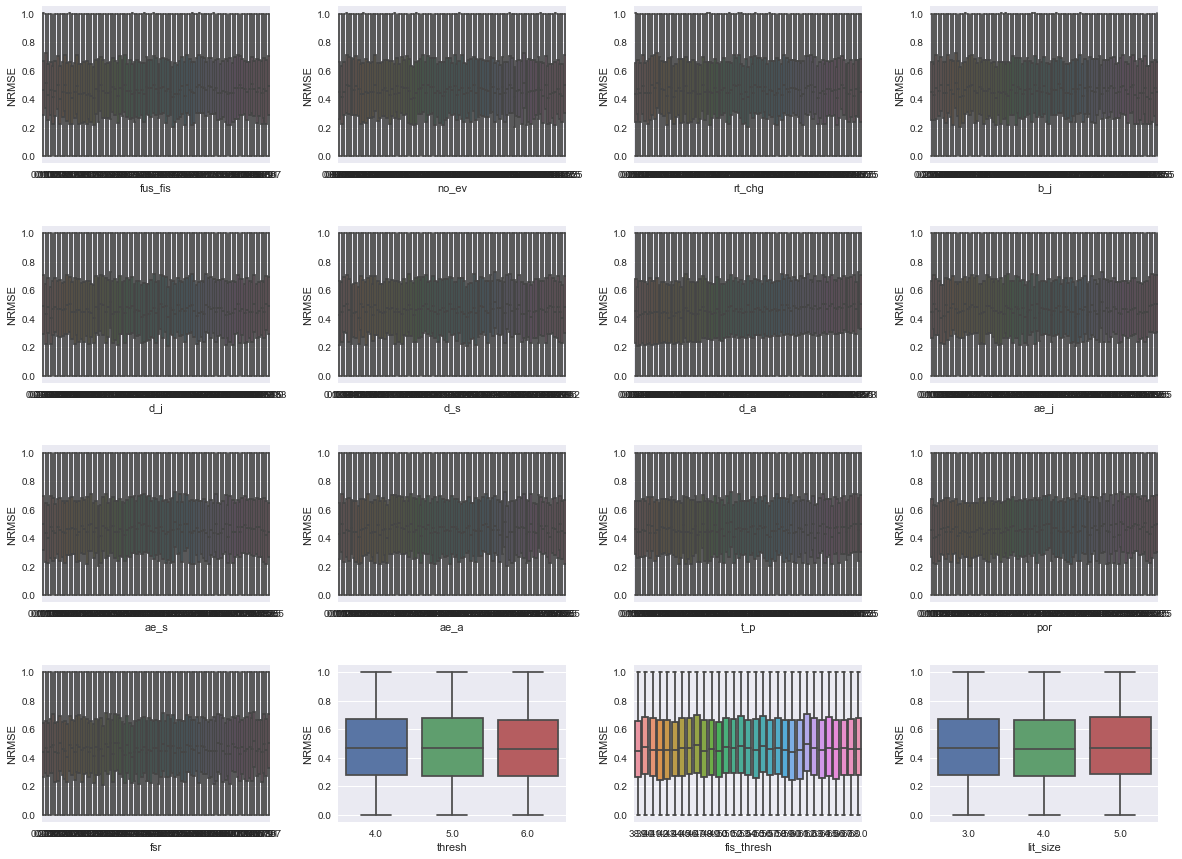

In [108]:
import seaborn as sns 

f,axes = plt.subplots(4,4,figsize=(20,15))
f.subplots_adjust(hspace = .4, wspace=.3)
axes=axes.ravel()
# Usual boxplot
for i in range(len(param_names)):
    sns.boxplot(x=param_names[i], y='NRMSE', data=res.loc[(res.NRMSE<1)],ax=axes[i],orient='v',).set(ylabel='NRMSE')
plt.savefig('../ABC_estimation/final_run/param_est.png')

# Recursive Feature Elimination

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [13]:
lim = 0.1
def classif(num,lim):
    if num <= lim:
        return 1
    else:
        return 0
    
df = res[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','NRMSE']]
df = df.loc[np.isnan(df.NRMSE)==False]
df.loc[:,'NRMSE'] = df.loc[:,'NRMSE'].apply(lambda x: classif(x,lim=lim))
df.head()

,fus_fis,no_ev,rt_chg,b_j,d_j,d_s,d_a,ae_j,ae_s,ae_a,t_p,por,fsr,thresh,fis_thresh,lit_size,NRMSE
0,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
1,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
2,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
3,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
4,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0


In [16]:
param_names = ['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size']

In [18]:
array = df.values
X = array[:,0:len(param_names)]
Y = array[:,len(param_names)]

model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 5
Selected Features: [False False False  True  True  True  True False False False False False
  True False False False]
Feature Ranking: [ 5  4  3  1  1  1  1  7  8  6 10  2  1 11 12  9]


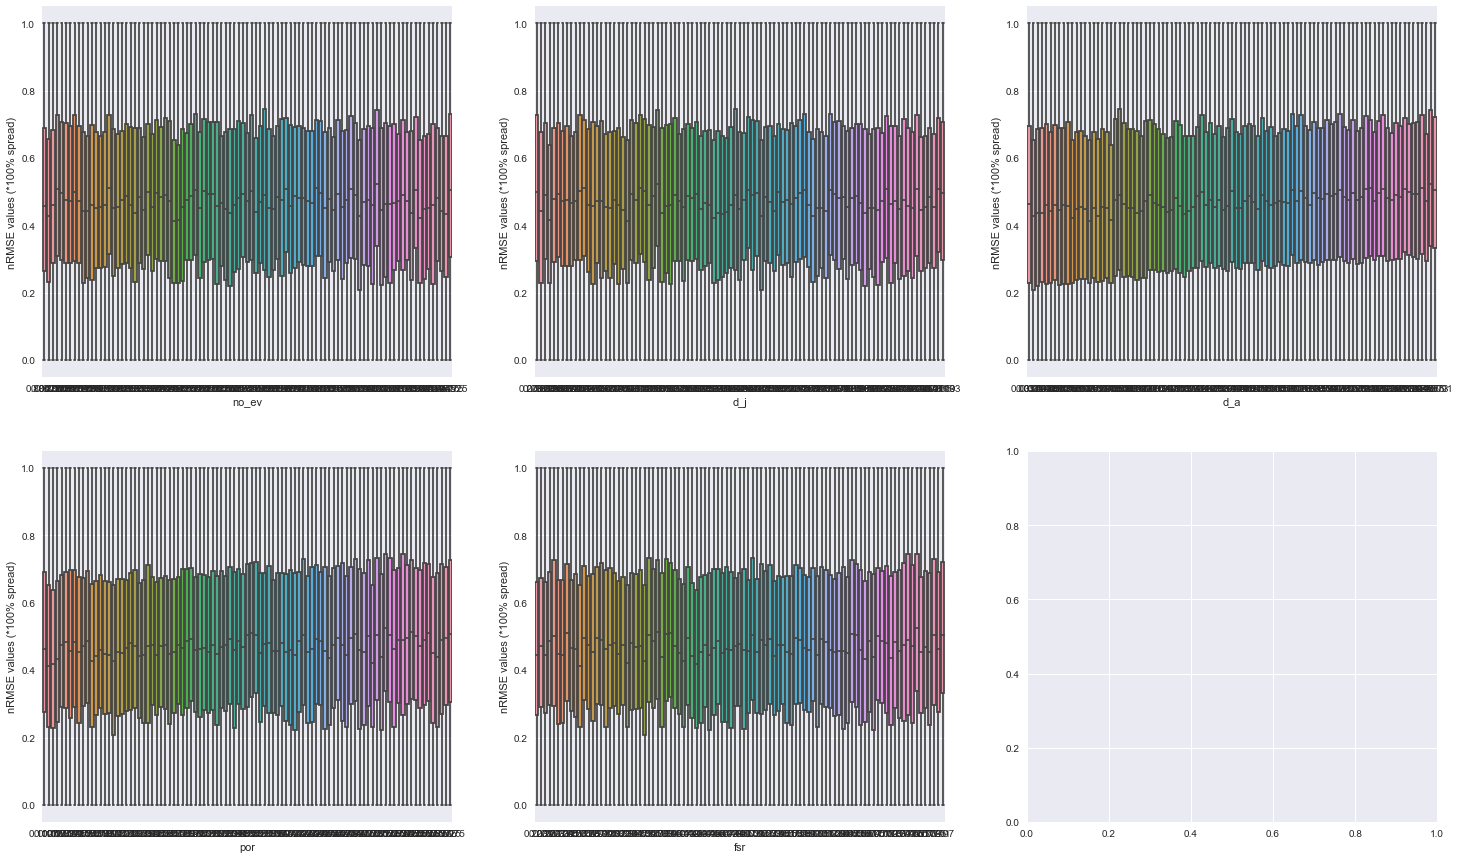

In [109]:
fig, axs = plt.subplots(2,3,figsize = (25,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)

axs = axs.ravel()

feat_names = ['no_ev','d_j','d_a','por','fsr']
temp = res[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','NRMSE']]
temp = temp.loc[temp.NRMSE <= 1]

for i in range(len(feat_names)):
    sns.boxplot(x=feat_names[i], y='NRMSE', data=temp,ax=axs[i],orient='v',).set(ylabel='NRMSE')
    axs[i].set_xlabel(feat_names[i])
    axs[i].set_ylabel('nRMSE values (*100% spread)')
plt.savefig('../ABC_estimation/feat_runs/feat_NRMSE_boxplots.png')

## RFE for 3D Viz

In [46]:
model = LogisticRegression()
rfe = RFE(model, 2)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
#print("Most Important Parameters: %s" % ['b_j','d_a'])

Num Features: 2
Selected Features: [False  True False False False False  True False False False False False
 False False False False]
Feature Ranking: [ 8  1  5 10  2  7  1 12  9  6 14  4  3 13 15 11]


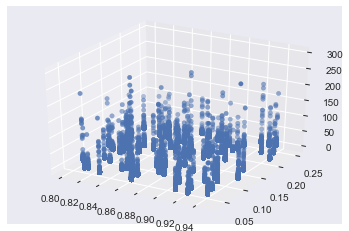

In [47]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.scatter3D(res.no_ev,res.d_a,res.NRMSE)

## By sMAPE

In [48]:
smape = res.loc[np.isnan(res.sMAPE)==False]
smape.sMAPE.unique()

array([ 49.57066579,  46.98051725,  51.78959766, ...,  68.35016835,
        14.3005279 ,  17.76231884])

In [105]:
df = res.loc[:,['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','sMAPE']]
df.loc[:,'sMAPE'] = df.loc[:,'sMAPE'].apply(lambda x: classif(x,lim=10))
df.head()

,fus_fis,no_ev,rt_chg,b_j,d_j,d_s,d_a,ae_j,ae_s,ae_a,t_p,por,fsr,thresh,fis_thresh,lit_size,sMAPE
0,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
1,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
2,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
3,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0
4,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,0


In [59]:
array = df.values
X = array[:,0:len(param_names)]
Y = array[:,len(param_names)]

model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 5
Selected Features: [False  True False False  True False  True False False False False  True
  True False False False]
Feature Ranking: [ 8  1  2  5  1  3  1 11  9  7  6  1  1 10 12  4]


In [63]:
print("Most Important Parameters: %s" % ['no_ev','d_j','d_a','por','fsr'])

Most Important Parameters: ['no_ev', 'd_j', 'd_a', 'por', 'fsr']


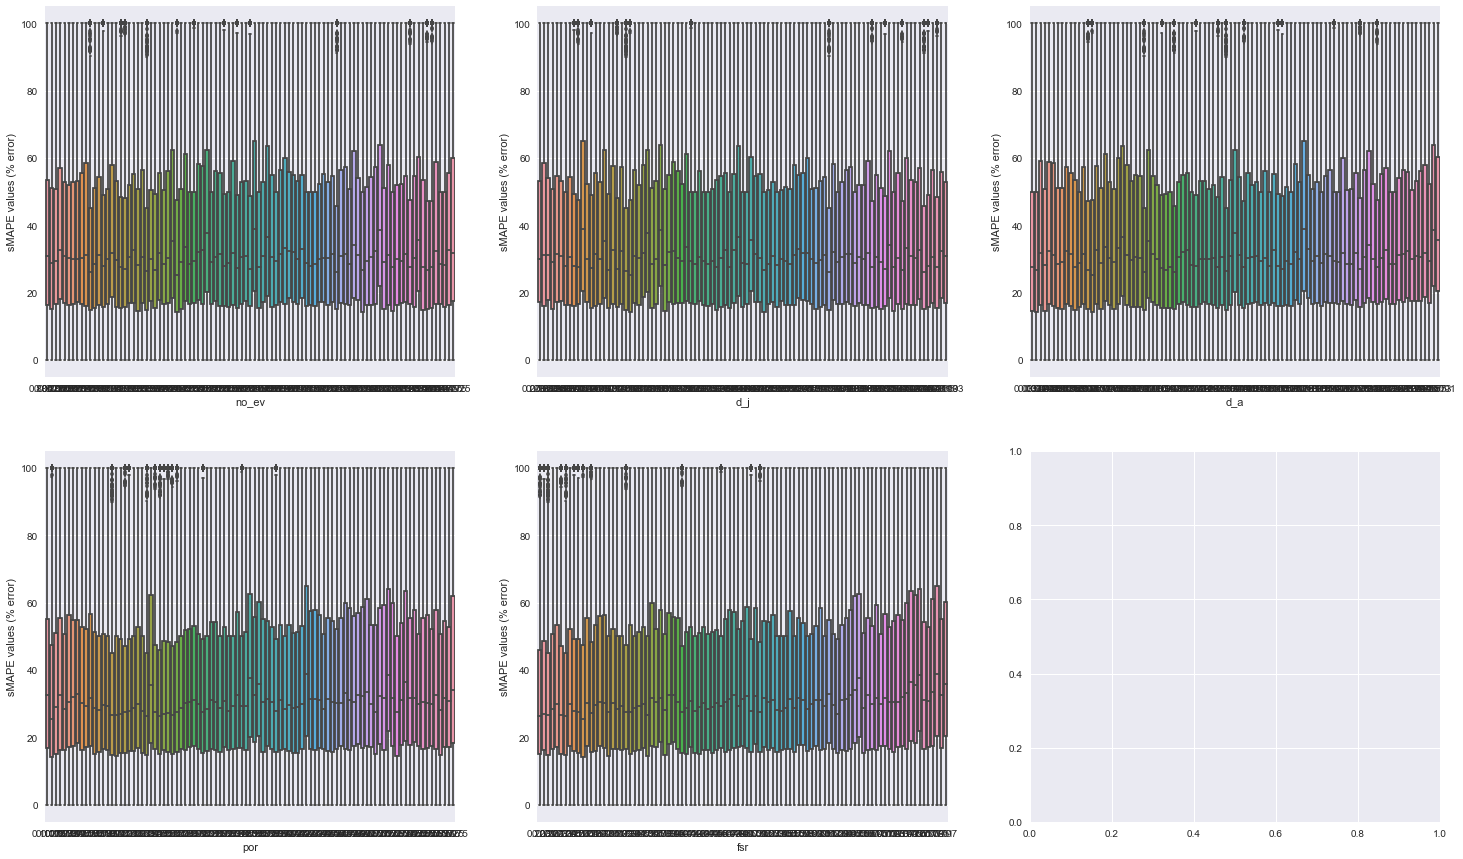

In [110]:
fig, axs = plt.subplots(2,3,figsize = (25,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)

axs = axs.ravel()

feat_names = ['no_ev','d_j','d_a','por','fsr']
temp = res[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','sMAPE']]
temp = temp.loc[temp.sMAPE <= 100]

for i in range(len(feat_names)):
    sns.boxplot(x=feat_names[i], y='sMAPE', data=temp,ax=axs[i],orient='v',).set(ylabel='sMAPE')
    axs[i].set_xlabel(feat_names[i])
    axs[i].set_ylabel('sMAPE values (% error)')
    
plt.savefig('../ABC_estimation/feat_runs/feat_sMAPE_boxplots.png')

## By Relative Error

In [104]:
df = res.loc[:,['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','rel_err']]
df.loc[:,'rel_err'] = df.loc[:,'rel_err'].apply(lambda x: classif(x,lim=1))
df.head()

,fus_fis,no_ev,rt_chg,b_j,d_j,d_s,d_a,ae_j,ae_s,ae_a,t_p,por,fsr,thresh,fis_thresh,lit_size,rel_err
0,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,1
1,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,1
2,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,1
3,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,1
4,0.169,0.84875,0.24575,0.28235,0.32423,0.2424,0.07215,0.3485,0.5655,0.6355,0.53225,0.4925,0.779,5.0,62.0,4.0,1


In [95]:
array = df.values
X = array[:,0:len(param_names)]
Y = array[:,len(param_names)]

model = LogisticRegression()
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 5
Selected Features: [False  True  True False  True False  True False False False False False
  True False False False]
Feature Ranking: [ 7  1  1  6  1  2  1  9  5 12  3  4  1 10 11  8]


In [96]:
print("Most Important Parameters: %s" % ['no_ev','rt_chg','d_j','d_a','fsr'])

Most Important Parameters: ['no_ev', 'rt_chg', 'd_j', 'd_a', 'fsr']


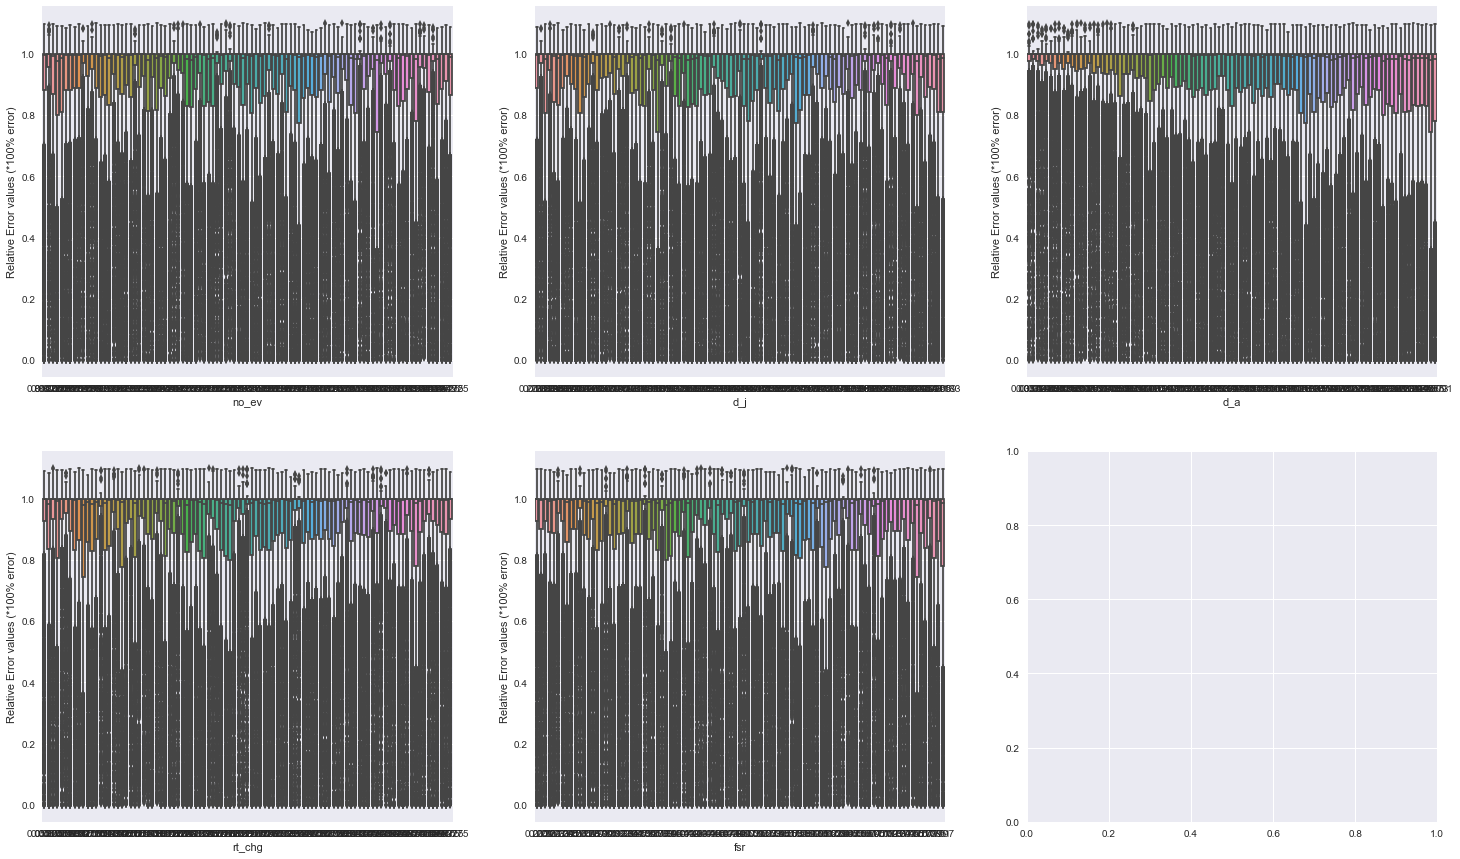

In [111]:
fig, axs = plt.subplots(2,3,figsize = (25,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.2)

axs = axs.ravel()

feat_names = ['no_ev','d_j','d_a','rt_chg','fsr']
temp = res[['fus_fis', 'no_ev', 'rt_chg', 'b_j', 'd_j', 'd_s', 'd_a', 'ae_j',
       'ae_s','ae_a', 't_p', 'por', 'fsr', 'thresh', 'fis_thresh','lit_size','rel_err']]
temp = temp.loc[temp.rel_err <= 1.1]

for i in range(len(feat_names)):
    sns.boxplot(x=feat_names[i], y='rel_err', data=temp,ax=axs[i],orient='v',).set(ylabel='rel_err')
    axs[i].set_xlabel(feat_names[i])
    axs[i].set_ylabel('Relative Error values (*100% error)')
    
plt.savefig('../ABC_estimation/feat_runs/feat_rel_err_boxplots.png')